# Customer Revenue Prediction


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import collections
from sklearn.preprocessing import LabelEncoder
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import lightgbm as lgbm
import gc
gc.enable()

In [7]:
train = pd.read_csv('E:/College/Analytics/Python/GA-Revenue/train_v2.csv')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
train.dtypes

channelGrouping         object
customDimensions        object
date                     int64
device                  object
fullVisitorId           object
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                  int64
visitNumber              int64
visitStartTime           int64
dtype: object

In [ ]:
train.shape

In [9]:
train.head(1)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450


In [10]:
train.isnull().sum().sort_values(ascending=False)

visitStartTime          0
visitNumber             0
visitId                 0
trafficSource           0
totals                  0
socialEngagementType    0
hits                    0
geoNetwork              0
fullVisitorId           0
device                  0
date                    0
customDimensions        0
channelGrouping         0
dtype: int64

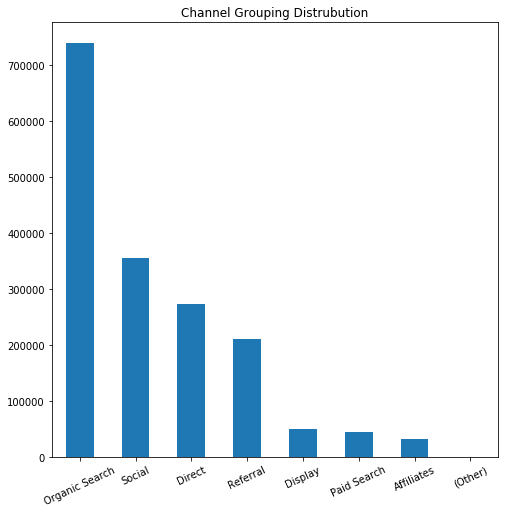

In [12]:
train['channelGrouping'].value_counts().plot(kind="bar",title="Channel Grouping Distrubution",figsize=(8,8),rot=25)

In [13]:
train['socialEngagementType'].value_counts()

Not Socially Engaged    1708337
Name: socialEngagementType, dtype: int64

In [14]:
train.head(1)[["date","visitStartTime"]]

,date,visitStartTime
0,20171016,1508198450


### Data Cleaning

In [ ]:
train["date"]=pd.to_datetime(train["date"],format="%Y%m%d")

In [ ]:
list_of_devices = train['device'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in device attribute are:{}".format(keys)

In [ ]:
device_df = pd.DataFrame(train.device.apply(json.loads).tolist())[["browser","operatingSystem","deviceCategory","isMobile"]]
device_df.head(5)

In [ ]:
list_of_devices = train['trafficSource'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in trafficSource attribute are:{}".format(keys)

In [ ]:
traffic_source_df = pd.DataFrame(train.trafficSource.apply(json.loads).tolist())[["keyword","medium" , "source"]]
traffic_source_df.head(5)

In [ ]:
list_of_devices = train['geoNetwork'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in geoNetwork attribute are:{}".format(keys)

In [ ]:
geo_df = pd.DataFrame(train.geoNetwork.apply(json.loads).tolist())[["continent","subContinent","country","city"]]
geo_df.head(5)

In [3]:
list_of_devices = train['totals'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in totals attribute are:{}".format(keys)

NameError: name 'train' is not defined

In [ ]:
totals_df = pd.DataFrame(train.totals.apply(json.loads).tolist())[["transactionRevenue", "newVisits", "bounces", "pageviews", "hits"]]
totals_df.head(5)

### Data Visualization

In [ ]:
sns.countplot(device_df['isMobile'])

In [ ]:
sns.countplot(device_df['deviceCategory'])

In [ ]:
device_df['operatingSystem'].value_counts().head(10).plot(kind="bar",title="OS Distrubution",figsize=(8,8),rot=25,color='teal')

In [ ]:
device_df['browser'].value_counts().head(10).plot(kind="bar",title="Browser Distrubution",figsize=(8,8),rot=25)

In [ ]:
plt.subplots(figsize=(7, 6))
sns.countplot(geo_df[geo_df['continent']== "Asia"]['subContinent'])

In [ ]:
geo_df[geo_df['continent']== "Asia"]['subContinent'].value_counts().plot(kind="bar",title="Asia Distrubution",figsize=(8,8),rot=0)

In [ ]:
traffic_source_df["source"].value_counts().head(10).plot(kind="bar",title="source",rot=75,color="teal")

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(15,10))
traffic_source_df["keyword"].value_counts().head(10).plot(kind="bar",ax=axes[0], title="keywords (total)",color="yellow")
traffic_source_df[traffic_source_df["keyword"] != "(not provided)"]["keyword"].value_counts().head(15).plot(kind="bar",ax=axes[1],title="keywords (dropping NA)",color="c")

In [ ]:
train["revenue"] = pd.DataFrame(train.totals.apply(json.loads).tolist())[["transactionRevenue"]]
revdat_df = train[["revenue", "date","visitNumber"]].dropna()
revdat_df["revenue"] = revdat_df.revenue.astype(np.int64)
plt.subplots(figsize=(20, 10))
plt.plot(revdat_df.groupby("date")["revenue"].sum())

In [ ]:
ab=revdat_df.groupby("date").sum()
fig, ax1 = plt.subplots(figsize=(20,10))
t = ab.index
s1 = ab["visitNumber"]
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('day')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('visitNumber', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
s2 = ab["revenue"]
ax2.plot(t, s2, 'r--')
ax2.set_ylabel('revenue', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))
ax.set_title("Histogram of log(visitNumbers) \n per session")
ax.set_ylabel("Repetition")
ax.set_xlabel("Log(visitNumber)")
ax.grid(color='b', linestyle='-', linewidth=0.1)
ax.hist(np.log(train['visitNumber']))

#### Most Common and Least Common

In [ ]:
tmp_least_visitNumbers_list = collections.Counter(list(train.visitNumber)).most_common()[:-10-1:-1]
tmp_most_visitNumbers_list = collections.Counter(list(train.visitNumber)).most_common(10)
least_visitNumbers = []
most_visitNumbers = []
for i in tmp_least_visitNumbers_list:
    least_visitNumbers.append(i[0])
for i in tmp_most_visitNumbers_list:
    most_visitNumbers.append(i[0])
"10 most_common visitNumbers are {} times and 10 least_common visitNumbers are {} times".format(most_visitNumbers,least_visitNumbers)

In [ ]:
train_all=pd.concat([train.drop(["hits"],axis=1),device_df,geo_df,traffic_source_df,totals_df],axis=1)
train_all.dtypes

In [ ]:
from datetime import datetime
train_all["month"] = train_all['date'].dt.month
train_all['visitHour'] = (train_all['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='month', y=train_all['transactionRevenue'].astype(np.float), data=train_all)

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x='visitHour', y=train_all['transactionRevenue'].astype(np.float), data=train_all)

In [ ]:
train_all.visitNumber.value_counts().head(10).plot(kind="bar",title="Vistor Numbers Distrubution",figsize=(8,8),rot=25,color='teal')

##### Final Dataframe

In [ ]:
df_train = train_all.drop(['date','month','device','geoNetwork','trafficSource','totals','customDimensions', 'socialEngagementType', 'visitStartTime', 'visitId', 'fullVisitorId' , 'revenue'], axis=1)
df_train.dtypes

In [ ]:
df_train.isnull().sum().sort_values(ascending=False)

In [ ]:
df_train=df_train.fillna(0)

numerical_features = ['transactionRevenue','visitNumber', 'newVisits', 'bounces', 'pageviews', 'hits']

for col in numerical_features:
    df_train[col] = df_train[col].astype(np.float)

In [ ]:
vst_rev=df_train.groupby('visitNumber')['transactionRevenue'].agg(['count','mean','sum'])
vst_rev.columns = ["count", "mean transaction","total revenue"]
vst_rev = vst_rev.sort_values(by="count", ascending=False)
sns.barplot(y=vst_rev['total revenue'].head(10),x=vst_rev.index[:10])

In [ ]:
sns.barplot(y=vst_rev['mean transaction'].head(10),x=vst_rev.index[:10])

In [ ]:
def feat_plot(col):
    pt = df_train.loc[:,[col, 'transactionRevenue']]
    feat_vis=pt.groupby(col)['transactionRevenue'].agg(['count','mean'])
    feat_vis.columns = ["count", "mean transaction value"]
    feat_vis['total_revenue'] = feat_vis['count']*feat_vis['mean transaction value']
    feat_vis = feat_vis.sort_values(by="count", ascending=False)
    plt.figure(figsize=(8, 16)) 
    plt.subplot(2,1,1)
    sns.barplot(x=feat_vis['count'].head(10), y=feat_vis.index[:10])
    plt.subplot(2,1,2)
    sns.barplot(x=feat_vis['mean transaction value'].head(10), y=feat_vis.index[:10])

In [ ]:
feat_plot('browser')

In [ ]:
feat_plot('country')

In [ ]:
feat_plot('operatingSystem')

In [ ]:
from wordcloud import WordCloud
source = df_train['source']
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(source))
plt.figure( figsize=(12,10) )
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

In [ ]:
categorical_features = ['channelGrouping', 'browser', 'operatingSystem', 'deviceCategory', 'isMobile',
                        'continent', 'subContinent', 'country', 'city', 'keyword', 'medium', 'source']    

for col in categorical_features:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))


### Light Gradient Boosting Model

In [ ]:
X=df_train.drop(['transactionRevenue'], axis=1)
y=np.log1p(df_train['transactionRevenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [ ]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7, 
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }


lgtrain = lgbm.Dataset(X_train, label=y_train)
lgval = lgbm.Dataset(X_test, label=y_test)
lgb_model = lgbm.train(params, lgtrain, valid_sets=[lgval], num_boost_round=2000, early_stopping_rounds=100, verbose_eval=100)
pred_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

In [ ]:
fig, ax = plt.subplots(figsize=(8,12))
lgbm.plot_importance(lgb_model, max_num_features=30, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
grid= {"min_child_weight":[4,5,6],"max_depth":[-1,1,3,5], "learning_rate":[0.1,0.01,0.2]}
lgb=LGBMRegressor(random_state=96,objective='regression',metric='rmse')
gridsearch= GridSearchCV(lgb,param_grid=grid,cv=5)
gridsearch.fit(X_train, y_train)
print(gridsearch.best_score_)
print(gridsearch.best_params_)

In [ ]:
lgb= LGBMRegressor(objective='regression',metric='rmse',learning_rate=0.1,min_child_weight=4)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
accuracy = lgb.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

In [ ]:
mean_absolute_error(y_test, lgb_pred)

In [ ]:
mean_squared_error(y_test, lgb_pred)

In [ ]:
np.sqrt(mean_squared_error(y_test, lgb_pred))

In [ ]:
coefs = pd.Series(lgb.feature_importances_, index = X_train.columns)
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.xlabel("LGB coefficient", weight='bold')
plt.title("Feature importance in the LightGB Model", weight='bold')
plt.show()